기본값 : 0  
INFO 로그 필터링 : 1  
WARNING 로그 필터링 : 2  
ERROR 로그 필터링 : 3  

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [3]:
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from datetime import datetime
import time
from tqdm import tqdm

https://wikidocs.net/31379

# 트랜스포머 구현

## 에셋 임베딩 레이어

In [16]:
class AssetAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, window_size, d_model, is_decoder=False, **kwargs):
        super(AssetAndPositionEmbedding, self).__init__(**kwargs)
        self.esset_emb = tf.keras.layers.Dense(d_model) #입력 데이터 shape : (batch_size, window_size)
        self.pos_emb = tf.keras.layers.Embedding(window_size, d_model)
        self.is_decoder = is_decoder
        self.__windowsize = window_size
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'is_decoder':self.is_decoder,
            '__windowsize':self.__windowsize
        })
        return config

    def call(self, x):
        L = tf.shape(x)[1] if self.is_decoder else self.__windowsize
        
        positions = tf.range(start=0, limit= L, delta=1)
        positions = self.pos_emb(positions)
        x = tf.reshape(x,(-1,L,1))
        x = self.esset_emb(x)
        return x + positions

## 스케일드 닷-프로덕트 어텐션(Scaled dot-product Attention)

In [17]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, 1, 1, key의 문장 길이)

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

## 멀티 헤드 어텐션(Multi-head Attention)

In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        # d_model을 num_heads로 나눈 값.
        # 논문 기준 : 64
        self.depth = d_model // self.num_heads

        # WQ, WK, WV에 해당하는 밀집층 정의
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # WO에 해당하는 밀집층 정의
        self.dense = tf.keras.layers.Dense(units=d_model)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_heads':self.num_heads,
            'd_model':self.d_model,
            'depth':self.depth
        })
        return config

    # num_heads 개수만큼 q, k, v를 split하는 함수
    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # 1. WQ, WK, WV에 해당하는 밀집층 지나기
        # q : (batch_size, query의 문장 길이, d_model)
        # k : (batch_size, key의 문장 길이, d_model)
        # v : (batch_size, value의 문장 길이, d_model)
        # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 2. 헤드 나누기
        # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
        # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
        # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 4. 헤드 연결(concatenate)하기
        # (batch_size, query의 문장 길이, d_model)
        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))

        # 5. WO에 해당하는 밀집층 지나기
        # (batch_size, query의 문장 길이, d_model)
        outputs = self.dense(concat_attention)

        return outputs

## 인코더 레이어

In [19]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
        'mask': None
    })

    # 드롭아웃 + 잔차 연결과 층 정규화
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
    outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 드롭아웃 + 잔차 연결과 층 정규화
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

In [20]:
def encoder(window_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 이번 일에서는 패딩이 존재X -> 패딩마스크X

    # 포지셔널 인코딩 + 드롭아웃
    embeddings = AssetAndPositionEmbedding(window_size,d_model)(inputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 인코더를 num_layers개 쌓기
    for i in range(num_layers):
        outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
                                dropout=dropout, name=f"encoder_layer_{i}",)([outputs])

    return tf.keras.Model(inputs=[inputs], outputs=outputs, name=name)

## 셀프 어텐션(Self-attention)과 룩-어헤드 마스크(Look-ahead mask)

In [21]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    return look_ahead_mask[tf.newaxis,tf.newaxis,:,:]

## 디코더 레이어

이걸 Dense여러층으로 바꿔보기!

enc_outputs가 들어온다.  
decode_input은 필요 없을지도?

In [22]:
def decoder(window_size, dff, d_model, dropout, name='decoder'):
    enc_outputs = tf.keras.Input(shape=(window_size, d_model), name='encoder_outputs')
    
    flatten_inputs = tf.keras.layers.Flatten()(enc_outputs)

    out1 = tf.keras.layers.Dense(units=dff, activation='relu')(flatten_inputs)
    out1_1 = tf.keras.layers.Dropout(rate=dropout)(out1)
    
    out2 = tf.keras.layers.Dense(units=d_model, activation='relu')(out1_1)
    outputs = tf.keras.layers.Dropout(rate=dropout)(out2)
    
    #outputs = tf.keras.layers.Dense(units=1)(out2_1)

    return tf.keras.Model(
        inputs=enc_outputs,
        outputs=outputs,
        name=name)

## 어텐션 레이어(enc-dec)

In [23]:
def attention_enc_dec(window_size,d_model,num_heads,name='attention_enc2dec'):
    asset_outputs = tf.keras.Input(shape=(window_size,d_model), name="asset_outputs")
    pos_outputs = tf.keras.Input(shape=(window_size,d_model), name="pos_outputs")
    neg_outputs = tf.keras.Input(shape=(window_size,d_model), name="neg_outputs")
    index_outputs = tf.keras.Input(shape=(window_size,d_model), name="index_outputs")
    
    concat_outputs = tf.keras.layers.concatenate([asset_outputs,pos_outputs,neg_outputs,index_outputs],name = "concatenate")
    #concat_outputs = tf.keras.layers.concatenate([pos_outputs,neg_outputs,index_outputs],name = "concatenate")
    
    enc_outputs = MultiHeadAttention(d_model=d_model,num_heads=num_heads, name="multi_head_attention")(inputs={
        'query': concat_outputs, 'key': concat_outputs, 'value': concat_outputs, 
        'mask': None
    })
    #enc_outputs = MultiHeadAttention(d_model=d_model,num_heads=num_heads, name="multi_head_attention")(inputs={
    #    'query': asset_outputs, 'key': concat_outputs, 'value': concat_outputs, 
    #    'mask': None
    #})
    return tf.keras.Model(inputs=[asset_outputs,pos_outputs,neg_outputs,index_outputs], outputs=enc_outputs, name=name)

## 멀티 인풋 siamese 인코더

In [24]:
#그냥도 되긴 한데, 그림 그릴 때 좀더 보기 좋으라고 하는 reshape레이어
class reshape_layer(tf.keras.layers.Layer):
    def __init__(self, shape_, **kwargs):
        super(reshape_layer,self).__init__(**kwargs)
        self.shape_ = shape_
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'shape_':self.shape_,
        })
        return config
    
    def call(self,inputs):
        return tf.reshape(inputs,self.shape_)

In [25]:
def siamese_enc_for_multi_input(window_size,num_layers,dff,d_model,num_heads,dropout,split_num,name=None):
    inputs = tf.keras.Input(shape=(split_num,window_size), name="inputs")
    
    squeeze_layer = reshape_layer((-1,window_size),name='squeeze')
    
    inputs_split = tf.split(inputs, num_or_size_splits=split_num, axis=1)
    for i in range(split_num):
        inputs_split[i] = squeeze_layer(inputs_split[i])
    outputs_concat = []
    
    siamese_enc = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                              d_model=d_model, num_heads=num_heads, dropout=dropout,name = "siamese_encoder")
    reshape = reshape_layer((-1,window_size,d_model,1), name='unsqueeze')
    for i in range(split_num):
        #siamese 구조
        outputs = siamese_enc(inputs=[inputs_split[i]])
        #outputs의 shape = (None,window_size,d_model)
        #reshape_layer안쓰려면 : outputs = tf.reshape(outputs,(-1,window_size,d_model,1))
        outputs = reshape(outputs)
        outputs_concat.append(outputs)
    outputs_concat = tf.keras.layers.concatenate(outputs_concat,axis=3,name = "concatenate")
    reduce_mean_outputs = tf.reduce_mean(outputs_concat,axis=3)
    return tf.keras.Model(inputs=[inputs], outputs=reduce_mean_outputs, name=name)

## 멀티 인코더 트랜스포머

In [26]:
def multi_enc_transformer(window_size, forecast_range, P, N, I, num_layers, dff,
                         d_model, num_heads, dropout,
                         name="transformer"):

    # 인코더의 입력
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    
    # 상관주 인코더의 입력 <- 여러 벡터가 인풋으로 들어가는데 이걸 해결할 방법은? MI-LSTM은 어떻게 처리했더라??
    pos_inputs = tf.keras.Input(shape=(P,window_size), name="pos_inputs")
    neg_inputs = tf.keras.Input(shape=(N,window_size), name="neg_inputs")
    
    # 인덱스 인코더의 입력 <- 여러 벡터가 인풋으로 들어가는데 이걸 해결할 방법은? MI-LSTM은 어떻게 처리했더라??
    index_inputs = tf.keras.Input(shape=(I,window_size), name="index_inputs")
    
    # 디코더의 입력
    #dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 디코더의 룩어헤드 마스크(첫번째 서브층).
    #look_ahead_mask = tf.keras.layers.Lambda(
    #    create_look_ahead_mask, output_shape=(1, None, None),
    #    name='look_ahead_mask')(dec_inputs)
    
    #에셋 인코더
    asset_outputs = encoder(window_size=window_size, num_layers=num_layers, dff=dff,
                          d_model=d_model, num_heads=num_heads, dropout=dropout,name = "asset_encoder")(inputs=[inputs])
    
    pos_outputs = siamese_enc_for_multi_input(window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,split_num=P,name="pos_siamese_encoder")(inputs=[pos_inputs])
    neg_outputs = siamese_enc_for_multi_input(window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,split_num=N,name="neg_siamese_encoder")(inputs=[neg_inputs])
    index_outputs = siamese_enc_for_multi_input(window_size=window_size,num_layers=num_layers,dff=dff,
                                              d_model=d_model,num_heads=num_heads,dropout=dropout,split_num=I,name="index_siamese_encoder")(inputs=[index_inputs])
    
    #concatenate-attention
    enc_outputs = attention_enc_dec(window_size,d_model,num_heads,name='attention_enc2dec')(inputs=[asset_outputs,pos_outputs,neg_outputs,index_outputs])#(None,25,64)
    
    # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
    dec_outputs = decoder(window_size=window_size, dff=dff, d_model=d_model, dropout=dropout,)(inputs=enc_outputs)

    # 다음 예측을 위한 출력층
    #outputs = tf.keras.layers.Dense(units=forecast_range, name="outputs")(dec_outputs)
    outputs = tf.keras.layers.Dense(units=1, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs,pos_inputs,neg_inputs,index_inputs], outputs=outputs, name=name)

# 데이터 셋 만들기

In [28]:
M6_Universe = pd.read_csv('M6_Universe.csv')

start_date = "2021-05-15" #OGN에셋 길이에 맞춤
end_date = "2022-09-02"

os.makedirs("./stock/asset",exist_ok=True)

for asset in tqdm(M6_Universe.symbol):
    stock = yf.download(asset, start=start_date, end = end_date, progress = False)
    stock.to_csv("./stock/asset/"+asset+".csv")


100%|█████████████████████████████████████████| 100/100 [00:37<00:00,  2.69it/s]


In [29]:
os.makedirs("./stock/index",exist_ok=True)

#S&P500 / 나스닥 / 다우존스 / 미국채 10년물 금리 / 변동성 지수(S&P 500 지수 옵션에 기반한 변동성) / 골드만삭스 원자재 지수(선물옵션 기반) / 원유
Index_list = ["SP500", "NASDAQ", "DOWJONES", "TNX", "VIX", "GSCI" , "Oil"]
Index_code = ['ES=F', 'YM=F', 'NQ=F', '^TNX', '^VIX', 'GD=F', 'CL=F']

Index_pd = pd.DataFrame([Index_list, Index_code],index=['name','symbol']).transpose()

for i in tqdm(range(Index_pd.shape[0])):
    stock = yf.download(Index_pd.symbol[i], start=start_date, end = end_date, progress = False)
    stock.to_csv("./stock/index/"+Index_pd.name[i]+".csv")

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.33it/s]


## 데이터셋 클래스

In [30]:
class dataset_for_transformer:
    '''
    [22-08-19(화)]
    데이터셋 만들기(Ver.2)
    
    MI-LSTM처럼 상관 계수 구할 예정!
    에셋별 scaler를 수동 적용.
    Date_Range 생성.
    원본 유지.
    
    메모:
        * cal_corr / load_file / get_dataset 만들 예정
        * 인덱스도 corr을 계산하는게 좋을까, 아니면 따로 넣는게 좋을까?
        * 가격 그대로를 corr계산할까, 수익률[(현재-과거)/과거]로 계산할까?
        * corr계산의 길이는? window사이즈의 2~2.5배? 아니면 고정길이?
    
    Parameter:
        asset_list        : 사용 에셋 리스트. csv파일이 존재하는 에셋 이름으로 가지고 있어야함.
        index_list        : 사용 인덱스 리스트. csv파일이 존재하는 인덱스 이름으로 가지고 있어야함.
        pos_corr          : 양의 상관 계수의 주식 수.
        neg_corr          : 음의 상관 계수의 주식 수.
        path("./stock")   : 에셋, 인덱스 파일 경로. asset은 path+/asset에, index는 path+/index에 있어야 함.
        train_ratio(None) : trainset의 비율. None이면 test셋 만들지 않음.

    '''
    def __init__(self, asset_list, index_list, pos_corr, neg_corr, path = "./stock"):
        self.asset_list = asset_list
        self.index_list = index_list
        self.pos_corr = pos_corr
        self.neg_corr = neg_corr
        self.__file_path = path
        
        self.dataset_asset = self.load_file(self.asset_list,"/asset")
        self.dataset_index = self.load_file(self.index_list,"/index")
        
        self.dataset_asset_scaled = self.dataset_asset.copy()
        self.dataset_index_scaled = self.dataset_index.copy()
    
    def calculate_correlation(self,dataset,window_size):
        #get_dataset안에서 사용될 예정
        #에셋 이름을 받을 것이고, 길이는 이 함수 전에 미리 자를 것(window_size의 1.5배 정도)
        #dataset은 (corr계산길이 * 100)인 pd.DataFrame
        corr_dataset = dataset.corr(method='pearson').copy()
        cut_dataset = dataset.iloc[-window_size:,:].copy()
        
        hist_idxs = [i for i in range(0,self.pos_corr+1)]#target+양의 corr 개수
        hist_idxs.extend([i for i in range(-self.neg_corr,0,1)])#음의 corr 개수
        
        target_np = []
        pos_np = []
        neg_np = []
        for i in range(100):
            select_asset = corr_dataset.iloc[:,i].sort_values(ascending=False).index[hist_idxs].to_list()
            
            target_np.append(cut_dataset[select_asset[0]].to_numpy()[np.newaxis,:])
            pos_np.append(cut_dataset[select_asset[1:self.pos_corr+1]].to_numpy().T[np.newaxis,:])
            neg_np.append(cut_dataset[select_asset[-self.neg_corr:]].to_numpy().T[np.newaxis,:])
        
        target_np = np.concatenate(target_np,axis=0) #(100, window_size)
        pos_np = np.concatenate(pos_np,axis=0) #(100, self.pos_corr, window_size)
        neg_np = np.concatenate(neg_np,axis=0) #(100, self.neg_corr, window_size)
        return {'target':target_np,
                'pos':pos_np,
                'neg':neg_np}
    
    def get_dataset(self, window_size, forecast_range = 20, corr_length_ratio = 1.5):
        W = window_size
        corr_length = round(W * corr_length_ratio)
        dataset_length = self.dataset_asset.shape[0]
        
        targets = []
        positives = []
        negatives = []
        indexes = []
        Ys = []
        for start_idx in tqdm(range(dataset_length-corr_length-forecast_range),desc='create dataset... '):
            calc_data = self.calculate_correlation(self.dataset_asset_scaled.iloc[start_idx:start_idx+corr_length,:], W)
            index_ = self.dataset_index_scaled.iloc[start_idx+corr_length-W:start_idx+corr_length,:].copy().to_numpy().T#(인덱스 개수, window_size)
            index_data=[index_[np.newaxis,:,:].copy() for _ in range(100)]
            index_data=np.concatenate(index_data,axis=0)#(100,인덱스 개수, window_size)
            #총 길이 forecast_range+1이 되도록(일단은)
            Y = self.dataset_asset_scaled.iloc[start_idx+corr_length-1:start_idx+corr_length+forecast_range,:].copy().to_numpy().T#(100,forecast_range+1)
            
            targets.append(calc_data['target'].copy())
            positives.append(calc_data['pos'].copy())
            negatives.append(calc_data['neg'].copy())
            indexes.append(index_data.copy())
            Ys.append(Y.copy())
            
        targets=np.concatenate(targets,axis=0)
        positives=np.concatenate(positives,axis=0)
        negatives=np.concatenate(negatives,axis=0)
        indexes=np.concatenate(indexes,axis=0)
        Ys=np.concatenate(Ys,axis=0)
        
        return {'target':targets,
                'positive':positives,
                'negative':negatives,
                'index':indexes,
                'Y':Ys}

    
    def load_file(self, file_list, sub_path):
        ASSET = file_list

        dataset_pd = None
        for asset in ASSET:
            data_one_asset = pd.read_csv(f"{self.__file_path}{sub_path}/{asset}.csv")[['Date','Adj Close']]
            data_one_asset.columns = ['Date',asset]
            if dataset_pd is None:
                dataset_pd = data_one_asset.copy()
            else:
                dataset_pd = pd.merge(left = dataset_pd, right = data_one_asset, how = 'outer', on = 'Date')
        dataset_pd['Date'] = pd.to_datetime(dataset_pd['Date'])
        dataset_pd.sort_values(by=['Date'],inplace=True)
        dataset_pd.reset_index(drop=True,inplace = True)
        dataset_pd.fillna(method='ffill',inplace=True)
        dataset_pd.fillna(method='bfill',inplace=True)
        return dataset_pd
    
    def apply_scale(self):
        dataset, indexset = self.dataset_asset.copy(), self.dataset_index.copy()
        
        merge_total = pd.merge(left=dataset, right=indexset, how='left', on='Date')
        merge_total.sort_values(by=['Date'], inplace=True)
        merge_total.fillna(method='ffill', inplace=True)
        merge_total.fillna(method='bfill', inplace=True)
        
        dataset_scaler = MinMaxScaler(feature_range=(-1, +1))
        indexset_scaler = MinMaxScaler(feature_range=(-1, +1))
        
        dataset_scaler.fit(merge_total[dataset.columns[1:]])
        indexset_scaler.fit(merge_total[indexset.columns[1:]])
        
        merge_total[dataset.columns[1:]] = dataset_scaler.transform(merge_total[dataset.columns[1:]])
        merge_total[indexset.columns[1:]] = indexset_scaler.transform(merge_total[indexset.columns[1:]])
        
        scaled_dataset = merge_total[dataset.columns[1:]].copy()
        scaled_indexset = merge_total[indexset.columns[1:]].copy()
        
        self.dataset_asset_scaled = scaled_dataset
        self.dataset_index_scaled = scaled_indexset
        self.asset_scaler = dataset_scaler
        self.index_scaler = indexset_scaler
        self.Date_range = merge_total['Date']
        

In [31]:
model_dataset = dataset_for_transformer(asset_list=M6_Universe.symbol, 
                                        index_list=Index_list, 
                                        pos_corr=10, 
                                        neg_corr=10)
model_dataset.apply_scale()

In [32]:
final_dataset = model_dataset.get_dataset(window_size=25, 
                                forecast_range = 20, 
                                corr_length_ratio = 1.5)
print(final_dataset['target'].shape,final_dataset['positive'].shape,final_dataset['negative'].shape,final_dataset['index'].shape,final_dataset['Y'].shape)

create dataset... : 100%|█████████████████████| 280/280 [00:22<00:00, 12.32it/s]


(28000, 25) (28000, 10, 25) (28000, 10, 25) (28000, 7, 25) (28000, 21)


## 데이터 셋 폼

dec_input 없애고, outputs를 log(y_21)-log(y_1)로 만들기

In [25]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
# inputs,pos_inputs,neg_inputs,index_inputs, dec_inputs

split_point=round(final_dataset['Y'].shape[0]*0.8)
print(split_point)

BATCH_SIZE = 128
BUFFER_SIZE = 20000

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': final_dataset['target'][:split_point],
        'pos_inputs':final_dataset['positive'][:split_point],
        'neg_inputs':final_dataset['negative'][:split_point],
        'index_inputs':final_dataset['index'][:split_point],
        'dec_inputs': final_dataset['Y'][:split_point, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'outputs': final_dataset['Y'][:split_point, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

2022-08-24 13:54:49.412610: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


21680


In [26]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': final_dataset['target'][split_point:],
        'pos_inputs':final_dataset['positive'][split_point:],
        'neg_inputs':final_dataset['negative'][split_point:],
        'index_inputs':final_dataset['index'][split_point:],
        'dec_inputs': final_dataset['Y'][split_point:, :-1] # 디코더의 입력. 마지막 값이 제거된다.(t 시점 ~ t+19 시점)
    },
    {
        'outputs': final_dataset['Y'][split_point:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 input의 마지막 값이 제거된다.(t+1 시점 ~ t+20 시점)
    },
))

test_dataset = test_dataset.cache()
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 생성

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


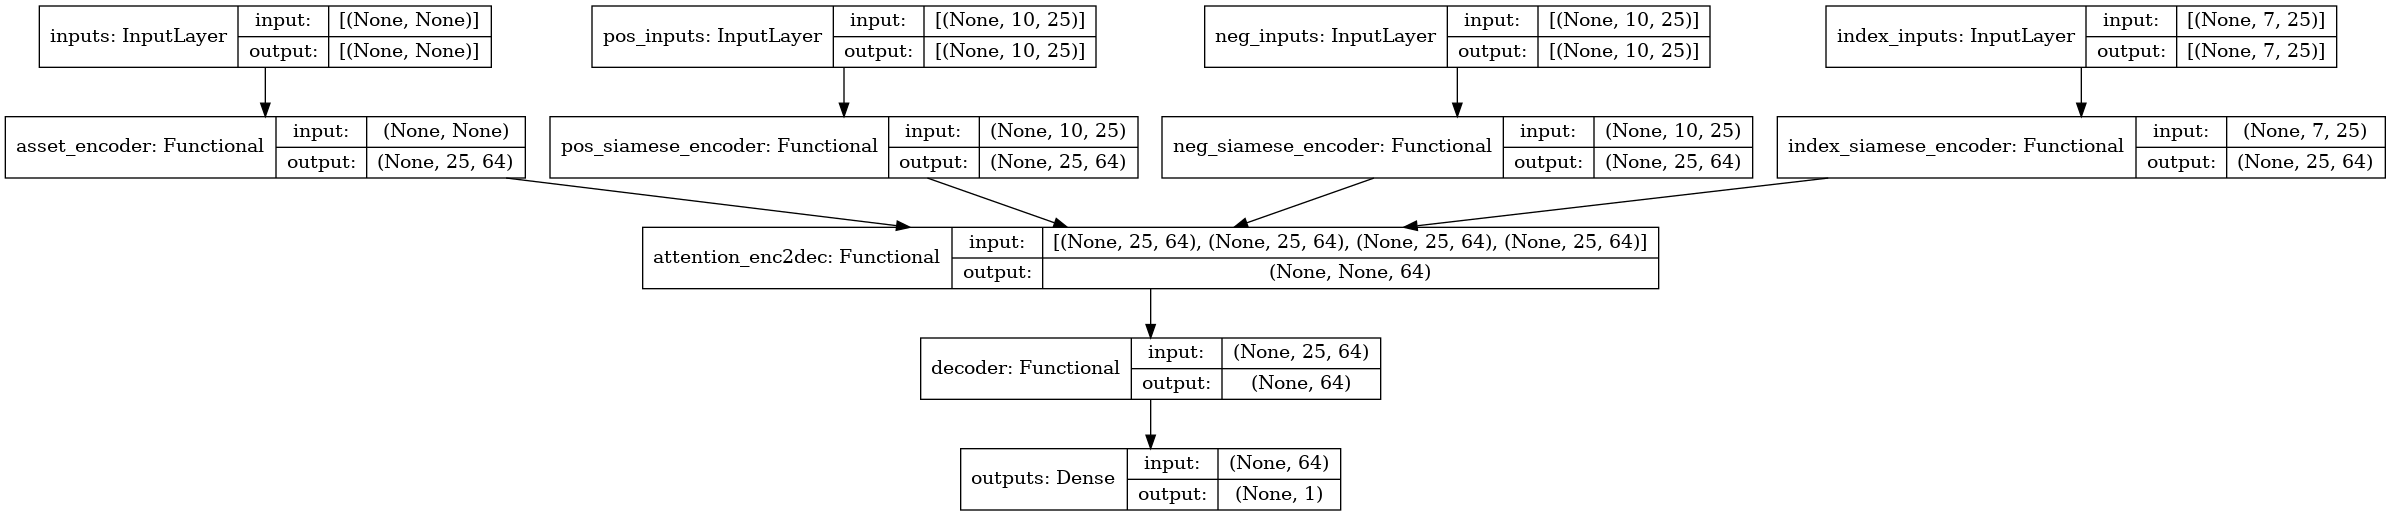

In [27]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
WINDOW_SIZE = 25
FORECAST_RANGE = 20
NUM_LAYERS = 4  #인코더, 디코더의 층 수
DFF = 128 #트랜스포머 내부의 피드-포워드 신경망의 은닉층 크기(입력층, 출력층은 d_model) 
D_MODEL = 64 #인코더, 디코더에서의 정해진 출력 크기 = 임베딩 벡터의 차원
NUM_HEADS = 8 #트랜스포머 내 어텐션에서 여러개로 분할 후 병렬로 어탠션 수행함. 이때의 병렬의 수
DROPOUT = 0.1

model = multi_enc_transformer(
    window_size = WINDOW_SIZE,
    forecast_range = FORECAST_RANGE,
    P=10,
    N=10,
    I=7,
    num_layers = NUM_LAYERS,
    dff = DFF,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT,
    name="stock_transformer")

callback_path = './transformer/ver_DENSE_return'
os.makedirs(callback_path, exist_ok=True)

tf.keras.utils.plot_model(model, to_file=f'{callback_path}/multi_encoder_transformer.png', show_shapes=True)

# 모델 학습!

In [ ]:
#model.compile(optimizer = tf.keras.optimizers.Adam(),
#              loss = tf.keras.losses.MeanSquaredError(),
#              metrics=[tf.keras.metrics.RootMeanSquaredError(),
#                       tf.keras.metrics.MeanAbsolutePercentageError()]
#             )
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.MeanSquaredError()
             )

In [ ]:
callback_path = './transformer/ver_DENSE_return'

os.makedirs(f'{callback_path}/ckpt', exist_ok=True)
ckpt_path = callback_path+'/ckpt/model_{epoch:03d}-{val_loss:.4f}.hdf5'
callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    ckpt_path,
    monitor='val_loss',
    save_best_only = True,
    verbose=1
)

os.makedirs(f'{callback_path}/tsbd', exist_ok=True)
callback_tsbd = tf.keras.callbacks.TensorBoard(f'{callback_path}/tsbd')

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.75 ** (epoch-5)
callback_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
lr = 0.001
e = np.arange(20)

r = [scheduler(e_,lr) for e_ in e]
plt.plot(e,r)

한 에폭에 약 400s

In [ ]:
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset, verbose = 1, callbacks=[callback_ckpt,callback_scheduler,callback_tsbd])

```bash
tensorboard --logdir=~/바탕화면/main_drive/LeeJaeYong/2.Transformer/transformer/ver_DENSE_return/tsbd
```